## 설명 가능한 딥러닝 모델

#### XAI(Explainable AI)
- 설명 가능한 딥러닝
- 예측의 근거를 설명해주는 기술
- 이미지를 사용해 이름이나 물건의 종류를 맞히는 모델을 만들었다면, 이미지의 어디를 보고 왜 그런 판단을 했는지 설명해 내는 또 다들 그림을 그려내는 것

In [1]:
!pip install tf-explain

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 43.6/43.6 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


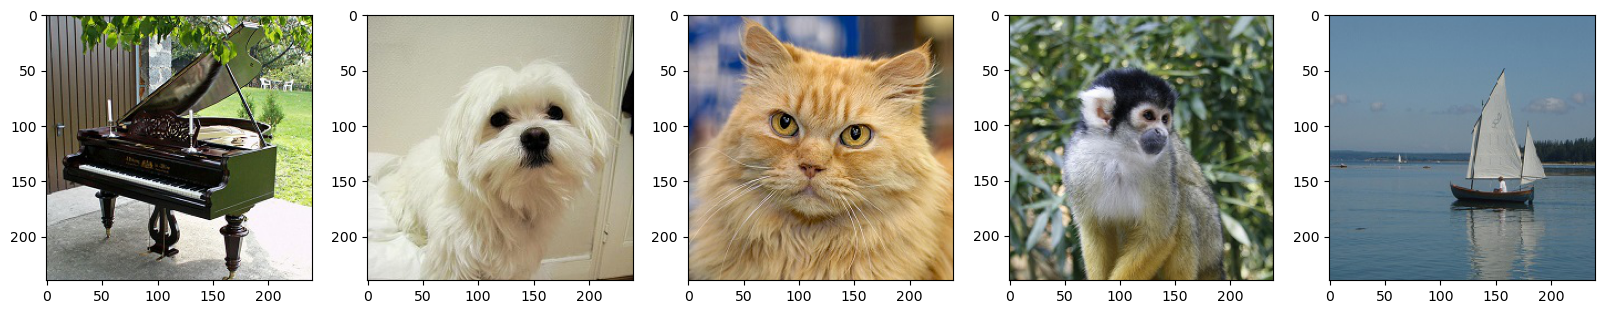

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

# XAI알고리즘을 불러오는 부분입니다.
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 원본 이미지가 들어갈 리스트 만들기
images_originals = []

# 원본 이미지가 저장된 폴더에서 하나씩 불러와 리스트에 넣기
for img_path in glob.glob('./data/img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))

# 주피터 노트북 상에서 보여질 이미지의 크기 
plt.figure(figsize=(20,20))

# 원본 이미지를 주피터 노트북에서 보이게 하기
for i, image_o in enumerate(images_originals):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_o)

### 딥러닝 결과를 설명하는 방법
***1. 딥러닝 중간과정에서 나온 특징 맵을 이용 => CAM(Class Activation Map)***
- CNN은 데이터가 입력이 되면 컨볼루션 레이어, 풀링 레이어에 통과시키는 것임
- 레이어들을 통과 시키는 이유는 신경망 학습을 위해 입력된 2D이미지들을 1차원 배열로 축소해야되기 때문
- 차원을 줄이는 과정에서 공간 정보의 손실이 발생하고, 이를 해소하기 위해 CNN이 만들어짐
- 다시말하면, 컨볼루션 신경망 내부의 레이어들을 하나씩 거쳐 마지막 예측을 위한 단계까지 온 데이터들(중간맵)은 데이터의 속성을 잘 간직하고 있음을 의미함
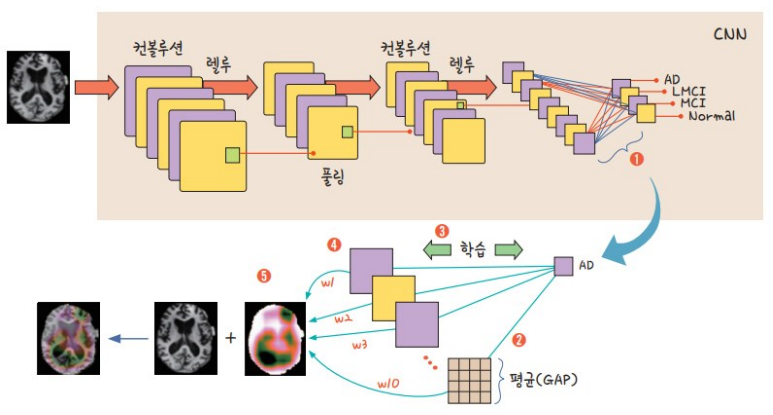
- CAM은 이 과정을 이용함
- 데이터를 1차원으로 축소시키는 Flatten 단계 직전에 개입해서 그때까지 만들어진 중간 맵들을 따로 모음
- 그 중간 맵들을 각각으로부터 평균값(Global Max Pooling,GAP)(중간맵 안에 들어있는 모든 값들의 평균)을 모은 후, 평균값과 최종 예측 사이에서 한번 더 학습
- 그러면 어떤 중간 맵이 최종 결정에 큰 역하을 하는지 알려주는 가중치를 얻게 됨
- 이 가중치를 각 중간 맵에 곱해 중요한 중간 맵은 가중하고 불필요한 중간 맵은 자연스럽게 없애면서 특징 맵을 만들어내는 과정이 CAM
<br>
- **Gradient CAM*** : 같은 원리로, 평균값을 계산하기 위해 모델의 구조를 바꾸어야 하는 번거러움을 피하고자 평균값 대신 기울기를 이용하는 CAM
***오클루전(폐쇄성 민감도/Occlusion Sensitivity)***
- 일부를 가리면서 가려진 부분이 결과에 얼마나 영향을 미치는지 계산하는 방식
- 마스크 방식이라고도 함
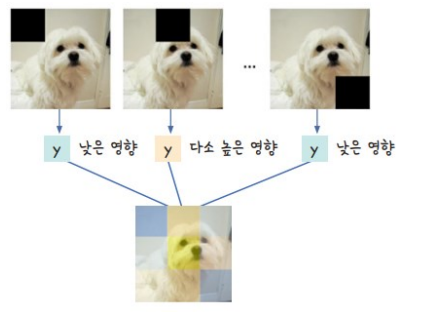

553467096/553467096 [==============================] - 59s 0us/step


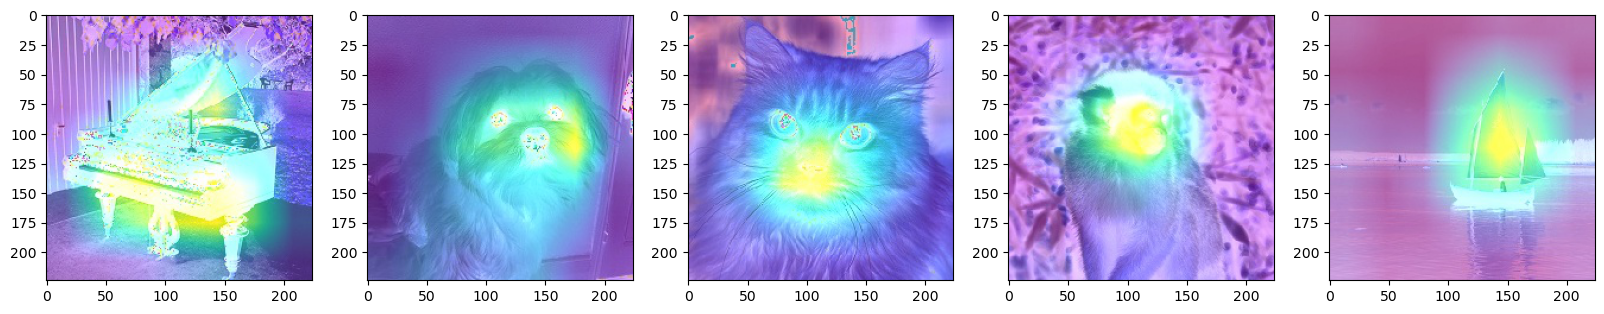

In [6]:
# 사전에 학습된 딥러닝 모델 불러오기
model = VGG16(weights="imagenet", include_top=True)

# 원본 이미지 이름과 Imagenet에서의 해당 이미지 인덱스
input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]

# 그레이디언트 CAM 알고리즘 선택
explainer = GradCAM()

# 그레이디언트 CAM 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_cams = []

# 그레이디언트 CAM 알고리즘 실행
for l, i in zip(input_list, imagenet_index):  
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224)) # 이미지를 불러오고 내부에서 처리될 이미지의 크기를 설정합니다. 
    img = img_to_array(img) # 이미지를 넘파이 배열로 바꾸어 줍니다.
    data = ([img], None)
    grid = explainer.explain(data, model, int(i))                 # 그레이디언트 CAM이 실행되는 부분입니다. 
    explainer.save(grid, ".", './data/img/{}_cam.jpg'.format(l)) # 실행 후 저장되는 이름입니다.

# 그레이디언트 CAM 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

색이 밝을수록 예측에 많은 기여를 했고, 파란색에  가까울 수록 기여도가 적다

- 원본 사진이랑 비교해 보았을 때(말티즈), 두 눈과 코가 밝고, 나머지는 대부분 푸른색 계열임을 확인
- 이 모델은 말티즈를 구분할 때 주로 눈과 코를 본다는 것을 알 수 있고, 이 덕분에 사용자에게 이 사진을 말티즈로 예측한 근거가 눈과 코라고 말할 수 있음

2/2 [==============================] - 8s 917ms/step


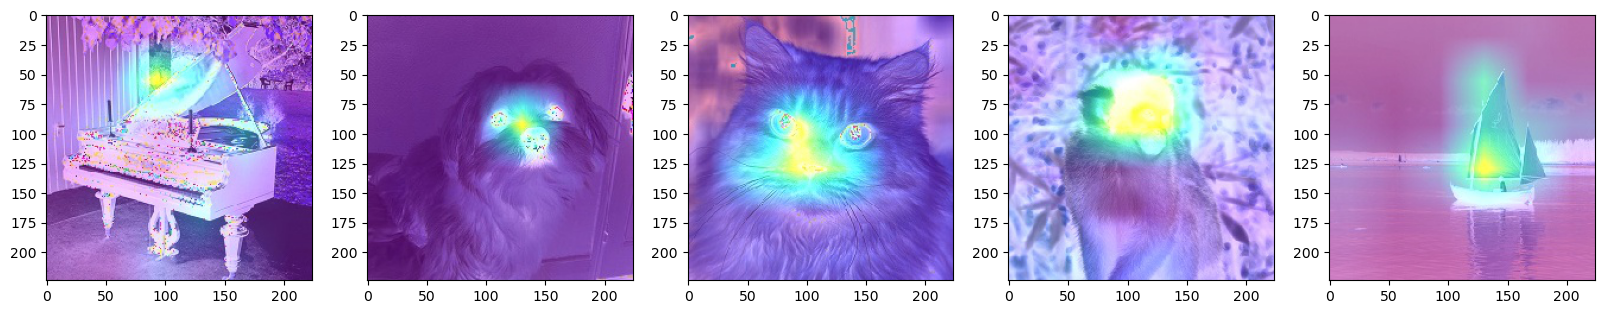

In [7]:
# 오클루전 알고리즘을 불러와 실행합니다.

explainer = OcclusionSensitivity()

# 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_occ1s = []

# 패치 사이즈를 정합니다. 
patch_size = 40

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) #패치 사이즈의 설정이 추가됩니다. 
    explainer.save(grid, ".", './data/img/{}_occ1.jpg'.format(l))

# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))

for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

5/5 [==============================] - 36s 7s/step


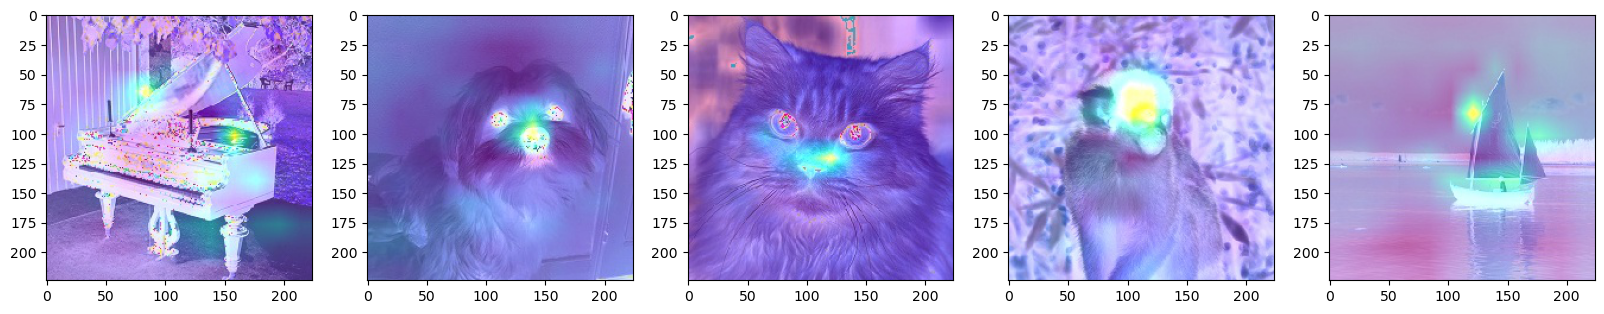

In [8]:
patch_size = 20

images_occ2s = []

for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) 
    explainer.save(grid, ".", './data/img/{}_occ2.jpg'.format(l))

for img_path in glob.glob('./data/img/*_occ2.jpg'):
    images_occ2s.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))
for i, image in enumerate(images_occ2s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

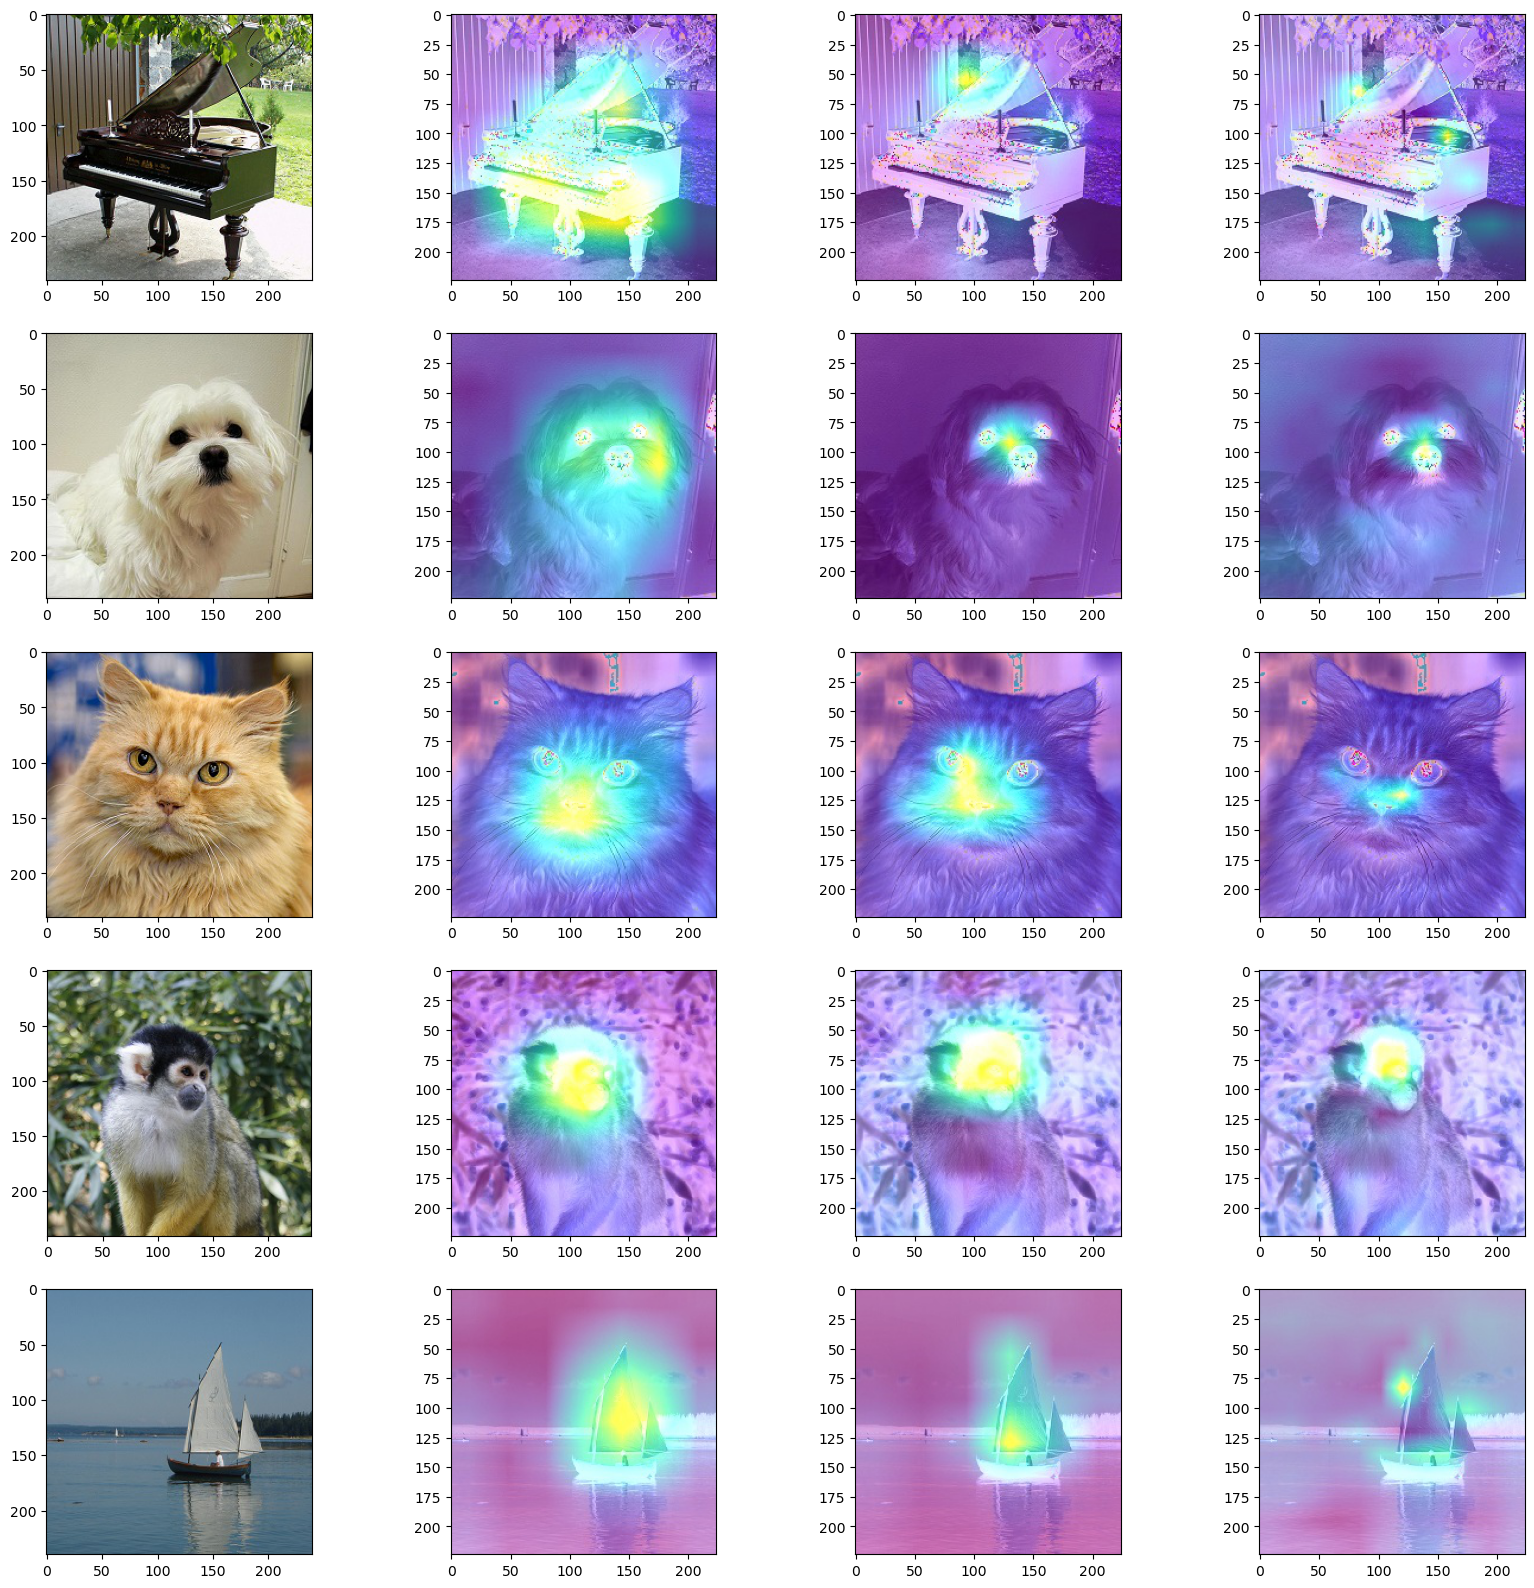

In [9]:
# 전체 이미지 한 눈에 보기.

plt.figure(figsize=(20,20))

images = []
for img_path in glob.glob('./data/img/*.jpg'):
    images.append(mpimg.imread(img_path))

for i, image in enumerate(images):
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)